# Time Stamp Extract

Brief 1-2 sentence description of notebook.

TODO: Supplement the description
- Notebook that extracts the timestamps and gets the time that tones played

In [100]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [101]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [102]:
git_root

'/nancy/projects/reward_competition_extention'

In [103]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [104]:
# Imports of all used packages and libraries
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [105]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [106]:
import utilities.helper
import trodes.read_exported

## Inputs & Data

- Explanation of each input and where it comes from.

Inputs and Required data loading
- input variable names are in all caps snake case
- Whenever an input changes or is used for processing 
- The variables are all lower in snake case

In [107]:
# Path of the directory that contains the Spike Gadgets recording and the exported timestamp files
# Exported with this tool https://docs.spikegadgets.com/en/latest/basic/ExportFunctions.html
# Export these files:
    # -raw – Continuous raw band export.
    # -dio – Digital IO channel state change export.
    # -analogio – Continuous analog IO export.
INPUT_DIR = "/scratch/back_up/reward_competition_extention/data"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
TONE_DIN = "dio_ECU_Din1"
TONE_STATE = 1
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "pilot2"

In [108]:
# TODO: Find way not to hard code this
ALL_SESSION_DIR = glob.glob("/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/*.rec")


In [109]:
ALL_SESSION_DIR

['/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Other documentation

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

## Functions

- function names are short and in snake case all lowercase
- a function name should be unique but does not have to describe the function
- doc strings describe functions not function names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [110]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# LOOP 1: Extracting all the Trodes

- Getting all the data from all the exported Trodes files

- Getting all the data from all the exported Trodes files and saving it to `session_to_trodes_data`
    - Creates a dictionary with the structure of:
        - `{dir_name: {file_name: metadata, file_name_2: metadata_2}, dir_name_2: {file_name_3: metadata_3, file_name_4: metadata_4}}`

In [111]:
# Saving the trodes data for each session
# Each key is a session name
# Each value is a dictionary of every recording file in that session
session_to_trodes_data = {}
# Saving the path of the session recording
session_to_path = {}

# Going through each session recording
# Which includes all the recordings from all the miniloggers and cameras
for session_path in ALL_SESSION_DIR:   
    try:
        # Getting the name of the session from the path
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        # Reading the trodes data for every recording file in the session directory
        session_to_trodes_data[session_basename] = trodes.read_exported.organize_all_trodes_export(session_path)
        
        session_to_path[session_basename] = session_path
    except Exception as e: 
        print(e)


Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1


/nancy/projects/reward_competition_extention/src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.timestampoffset.txt due to error: Settings format not supported


Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.timestampoffset.txt due to error: Settings format not supported


In [117]:
trodes_metadata_df = pd.DataFrame.from_dict({(i,j,k,l): session_to_trodes_data[i][j][k][l] 
                           for i in session_to_trodes_data.keys() 
                           for j in session_to_trodes_data[i].keys()
                           for k in session_to_trodes_data[i][j].keys()
                           for l in session_to_trodes_data[i][j][k].keys()},
                           orient='index')

trodes_metadata_df = trodes_metadata_df.reset_index()
trodes_metadata_df = trodes_metadata_df.rename(columns={'level_0': 'session_dir', 'level_1': 'recording', 'level_2': 'metadata_dir', 'level_3': 'metadata_file'}, errors="ignore")

trodes_metadata_df["session_path"] = trodes_metadata_df["session_dir"].map(session_to_path)

In [118]:
trodes_metadata_df.head()

,session_dir,recording,metadata_dir,metadata_file,description,byte_order,original_file,clockrate,trodes_version,compile_date,...,system_time_at_creation,timestamp_at_creation,first_timestamp,fields,data,direction,id,display_order,decimation,session_path
0,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,raw,coordinates,Pad locations in microns,little endian,20230618_100636_standard_comp_to_omission_D2_s...,20000,2.4.0,May 24 2023,...,1687097219606,489210,835680,<ml int32><dv int32><ap int32>,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...",NaN,NaN,NaN,NaN,/scratch/back_up/reward_competition_extention/...
1,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,raw,timestamps,Raw timestamps,little endian,20230618_100636_standard_comp_to_omission_D2_s...,20000,2.4.0,May 24 2023,...,1687097219606,489210,835680,<time uint32>,"[[835680], [835681], [835682], [835683], [8356...",NaN,NaN,NaN,NaN,/scratch/back_up/reward_competition_extention/...
2,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,DIO,dio_ECU_Dout3,State change data for one digital channel. Dis...,little endian,20230618_100636_standard_comp_to_omission_D2_s...,20000,2.4.0,May 24 2023,...,1687097219606,489210,835680,<time uint32><state uint8>,"[[835680, 0]]",output,ECU_Dout3,4,NaN,/scratch/back_up/reward_competition_extention/...
3,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,DIO,dio_ECU_Din1,State change data for one digital channel. Dis...,little endian,20230618_100636_standard_comp_to_omission_D2_s...,20000,2.4.0,May 24 2023,...,1687097219606,489210,835680,<time uint32><state uint8>,"[[835680, 0], [1934930, 1], [2134930, 0], [433...",input,ECU_Din1,7,NaN,/scratch/back_up/reward_competition_extention/...
4,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,DIO,dio_ECU_Dout1,State change data for one digital channel. Dis...,little endian,20230618_100636_standard_comp_to_omission_D2_s...,20000,2.4.0,May 24 2023,...,1687097219606,489210,835680,<time uint32><state uint8>,"[[835680, 0]]",output,ECU_Dout1,2,NaN,/scratch/back_up/reward_competition_extention/...


In [122]:
trodes_metadata_df["metadata_file"].unique()

array(['coordinates', 'timestamps', 'dio_ECU_Dout3', 'dio_ECU_Din1',
       'dio_ECU_Dout1', 'dio_ECU_Din4', 'dio_ECU_Dout4', 'dio_ECU_Din3',
       'dio_ECU_Dout2', 'dio_ECU_Din2'], dtype=object)

In [149]:
trodes_metadata_df["data"].iloc[2].dtype.names[0]

'time'

In [152]:
trodes_metadata_df["dtype_name"] = trodes_metadata_df["data"].apply(lambda x: x.dtype.names[0])

In [153]:
trodes_metadata_df["first_item_data"] = trodes_metadata_df["data"].apply(lambda x: x[x.dtype.names[0]])

# Code Draft

Things to do:
- Get these into Numpy arrays
    - ephys timestamps
        - ephys index
    - din states timestamps
        - din state index
    - videoframe ephys timestamps
        - video frame index
- Sync everything up and make it easy to connect between everything

- Chatgpt recommendation

```
Storing and cross-referencing timestamps from multiple different data streams in a way that facilitates easy analysis and manipulation can be efficiently achieved using pandas DataFrames in Python. Pandas is a powerful data manipulation library that provides various functionalities for handling time series data. Here's a conventional approach to organize and cross-reference timestamps:

    Use a Pandas DataFrame:
        Create a DataFrame for each data stream with timestamps as one of the columns.
        Ensure timestamps are in a consistent format across all DataFrames. It's recommended to use the ISO 8601 format (YYYY-MM-DD HH:MM:SS) or Unix time format.

    Standardize Timestamps:
        Convert all timestamps to a common timezone if they are from different timezones.
        Use pandas to convert timestamps to datetime objects for easier manipulation: pd.to_datetime(df['timestamp']).

    Indexing by Timestamps:
        Set the timestamp column as the index for each DataFrame: df.set_index('timestamp', inplace=True). This allows for efficient slicing and dicing of the data based on time.

    Synchronize Timestamps:
        If your data streams have timestamps at different intervals, you may need to synchronize them.
        Resample or interpolate data to a common time frequency if needed: df.resample('1T').mean() resamples data to a 1-minute interval.

    Merge or Join DataFrames:
        Use pandas functions like merge or join to combine multiple DataFrames based on timestamps.
        You can perform inner, outer, left, or right joins depending on how you want to handle timestamps that don't match across DataFrames.

    Handling Missing Data:
        If there are missing timestamps in one stream relative to another, decide how to handle them (e.g., fill forward, interpolate, or leave as NaN).

    Querying and Analysis:
        With timestamps as indices, you can easily query specific time ranges, compute time-based aggregates, or perform time-series analyses.

    Storing DataFrames:
        Save your synchronized DataFrames to a file for future use. You can use formats like CSV, Excel, or HDF5, but for large time-series data, HDF5 or Parquet are more efficient.

Example code snippet:
```

# LOOP 2: Extracting the timestamps for the raw ephys recording

- Getting the timestamps for all samples in the recording

20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
dio_ECU_Din1


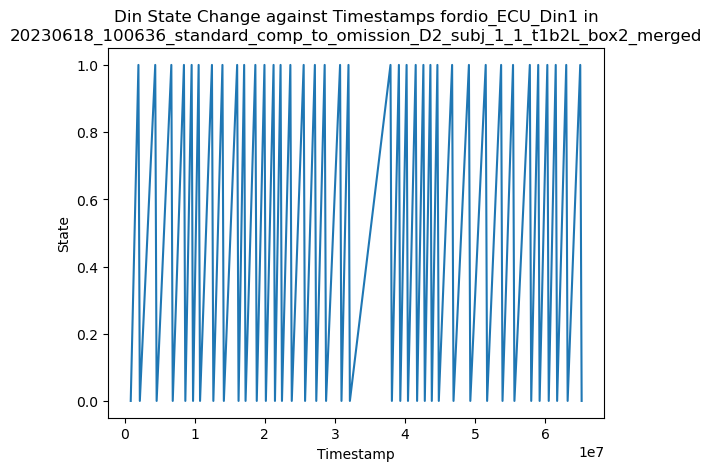

dio_ECU_Din4


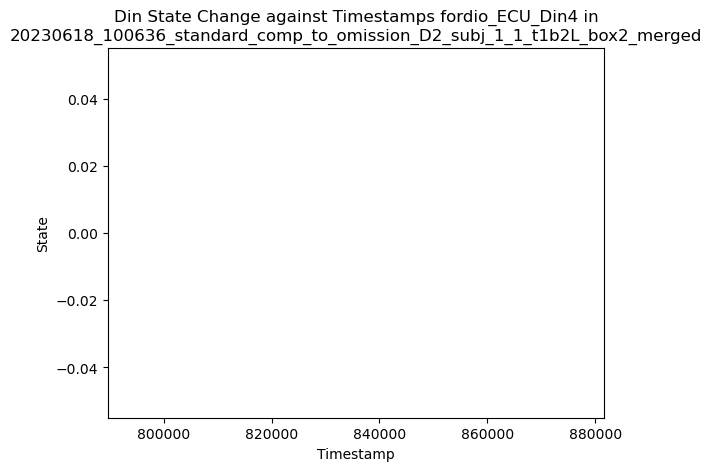

dio_ECU_Din3


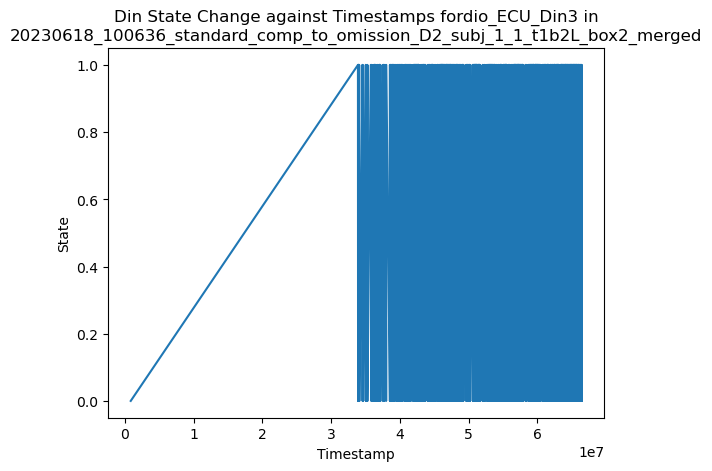

dio_ECU_Din2


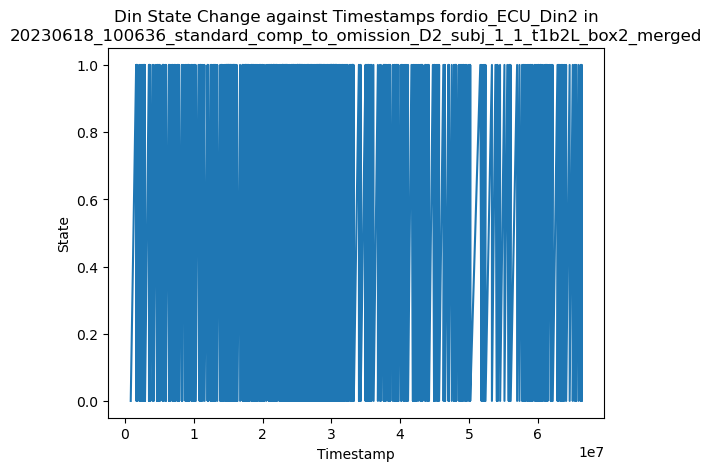

20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
dio_ECU_Din2


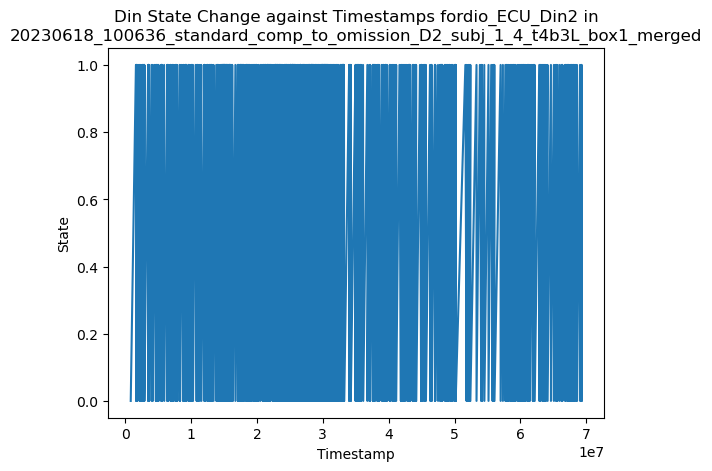

dio_ECU_Din3


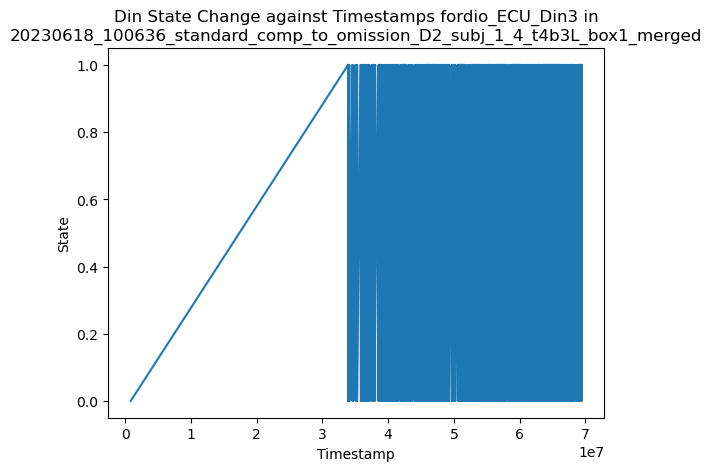

dio_ECU_Din4


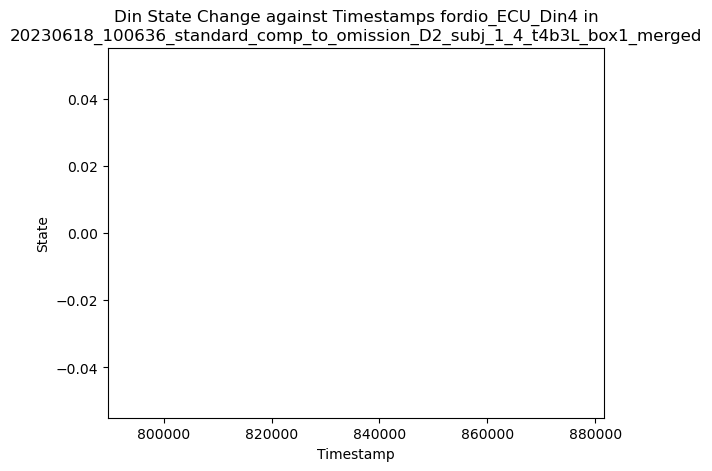

dio_ECU_Din1


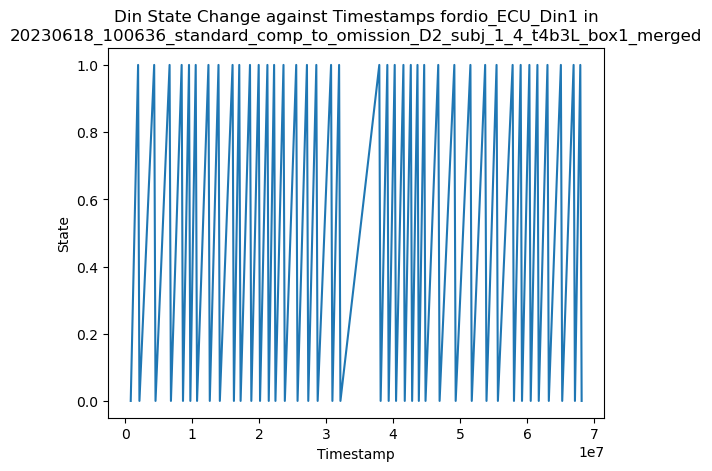

In [ ]:
session_to_din_state_df = {}
# Iterating through each recording session
for session, file_to_data in session_to_trodes_data.items():
    
    all_recording_din_state_df = []


    
    for recording_name, subdir_dict in file_to_data.items():
        print(recording_name)
        current_recording_din_state_df = []

        try:
            voltage_timestamp_array = file_to_data[recording_name]["raw"]["timestamps"]["data"]
            for key, value in file_to_data[recording_name]["DIO"].items():
                if "in" in key:
                    print(key)
                    din_state_array = file_to_data[recording_name]["DIO"][key]["data"]
                    current_din_state_df = pd.DataFrame(din_state_array)
                    current_din_state_df["recording_path"] = session_to_path[session]
                    current_din_state_df["recording_dir"] = session
                    current_din_state_df["recording_file"] = recording_name
                    current_din_state_df["din"] = key
                    current_recording_din_state_df.append(current_din_state_df)
                    plt.plot([tup[0] for tup in din_state_array], [tup[1] for tup in din_state_array])
                    plt.xlabel("Timestamp")
                    plt.ylabel("State")
                    plt.title("Din State Change against Timestamps for{} in\n{}".format(key, recording_name))
                    plt.show()
                    plt.close()
            concatted_per_recording_din_state_df = pd.concat(current_recording_din_state_df).sort_values(by=["recording_file", "din"]).reset_index(drop=True)
            concatted_per_recording_din_state_df["time_stamp_index"] = concatted_per_recording_din_state_df["time"] - voltage_timestamp_array[0][0]
            all_recording_din_state_df.append(concatted_per_recording_din_state_df)
        except Exception as e: 
            print(e)
    concatted_all_recording_din_state_df = pd.concat(all_recording_din_state_df)
    session_to_din_state_df[session] = concatted_all_recording_din_state_df

In [ ]:
all_recording_din_state_df

[          time  state                                     recording_path  \
 0       835680      0  /scratch/back_up/reward_competition_extention/...   
 1      1934930      1  /scratch/back_up/reward_competition_extention/...   
 2      2134930      0  /scratch/back_up/reward_competition_extention/...   
 3      4334936      1  /scratch/back_up/reward_competition_extention/...   
 4      4534932      0  /scratch/back_up/reward_competition_extention/...   
 ...        ...    ...                                                ...   
 3643  66433509      1  /scratch/back_up/reward_competition_extention/...   
 3644  66434509      0  /scratch/back_up/reward_competition_extention/...   
 3645  66435106      1  /scratch/back_up/reward_competition_extention/...   
 3646  66437909      0  /scratch/back_up/reward_competition_extention/...   
 3647    835680      0  /scratch/back_up/reward_competition_extention/...   
 
                                           recording_dir  \
 0     2023061

# LOOP 2: Extracting the timestamps for ECU Events

20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
dio_ECU_Din1


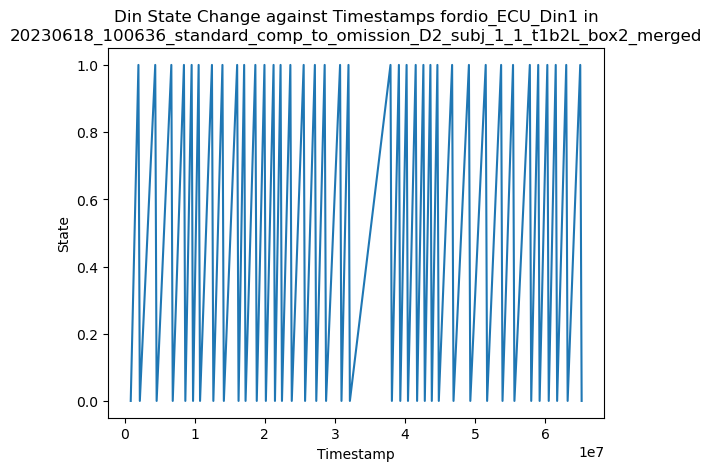

dio_ECU_Din4


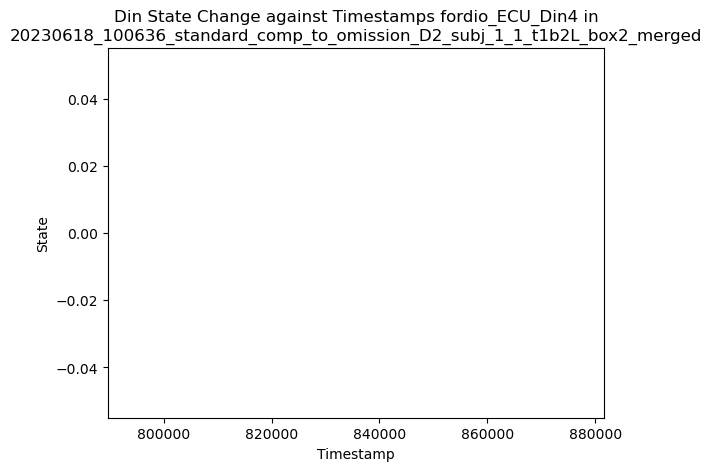

dio_ECU_Din3


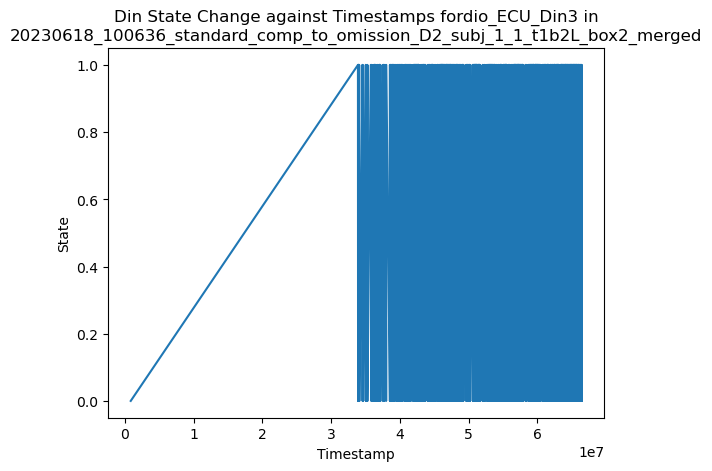

dio_ECU_Din2


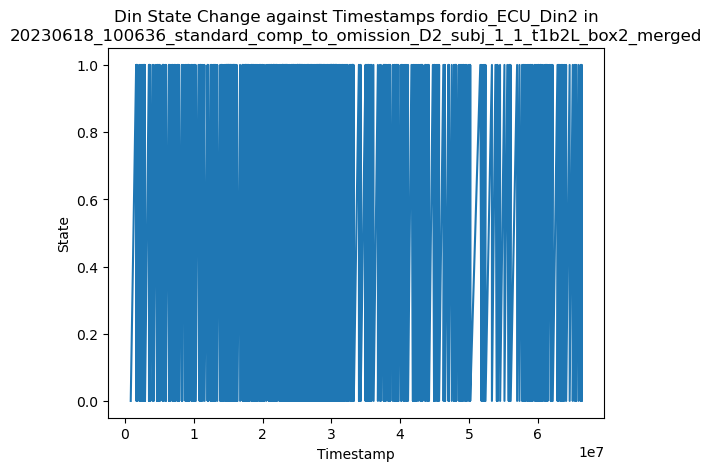

20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
dio_ECU_Din2


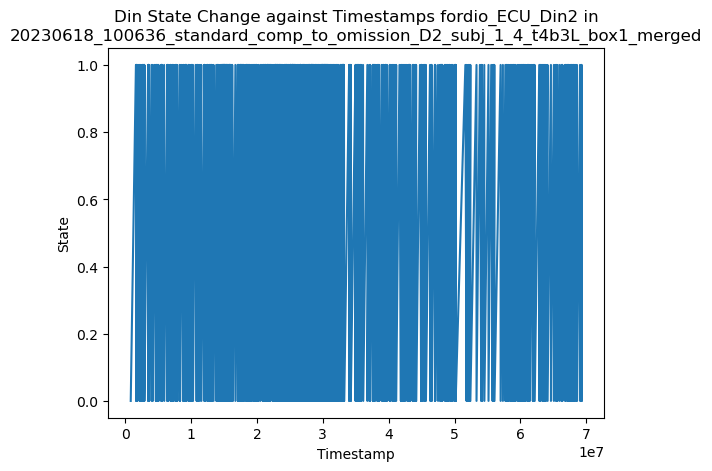

dio_ECU_Din3


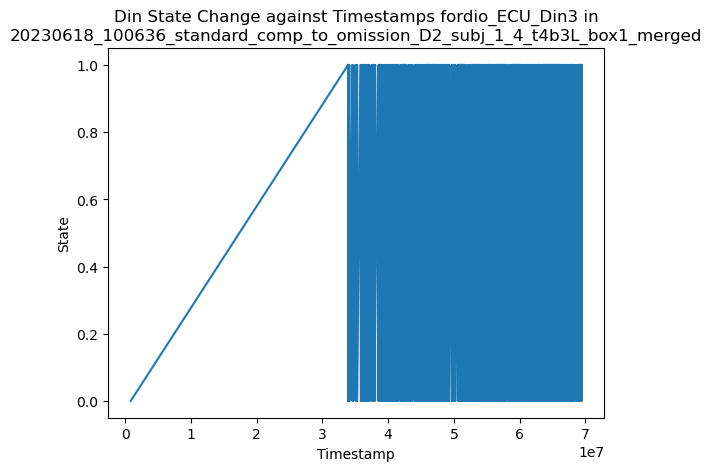

dio_ECU_Din4


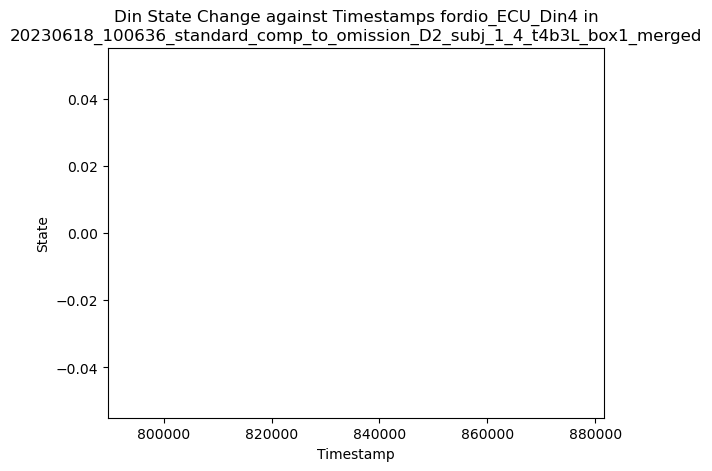

dio_ECU_Din1


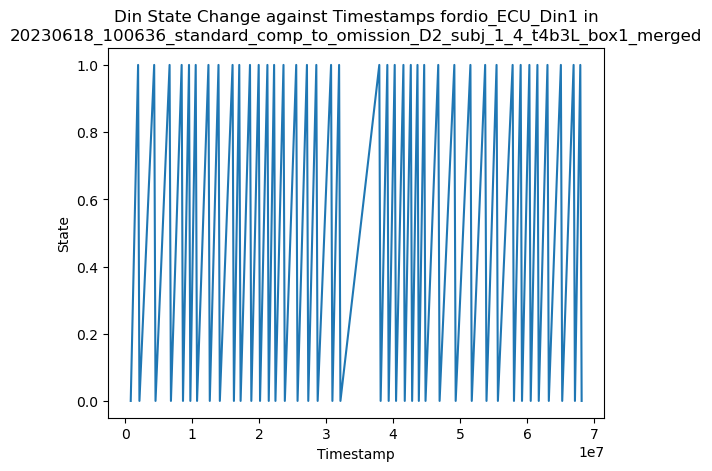

In [ ]:
session_to_din_state_df = {}
for session, file_to_data in session_to_trodes_data.items():
    all_recording_din_state_df = []
    for recording_name, subdir_dict in file_to_data.items():
        print(recording_name)
        current_recording_din_state_df = []

        try:
            voltage_timestamp_array = file_to_data[recording_name]["raw"]["timestamps"]["data"]
            for key, value in file_to_data[recording_name]["DIO"].items():
                if "in" in key:
                    print(key)
                    din_state_array = file_to_data[recording_name]["DIO"][key]["data"]
                    current_din_state_df = pd.DataFrame(din_state_array)
                    current_din_state_df["recording_path"] = session_to_path[session]
                    current_din_state_df["recording_dir"] = session
                    current_din_state_df["recording_file"] = recording_name
                    current_din_state_df["din"] = key
                    current_recording_din_state_df.append(current_din_state_df)
                    plt.plot([tup[0] for tup in din_state_array], [tup[1] for tup in din_state_array])
                    plt.xlabel("Timestamp")
                    plt.ylabel("State")
                    plt.title("Din State Change against Timestamps for{} in\n{}".format(key, recording_name))
                    plt.show()
                    plt.close()
            concatted_per_recording_din_state_df = pd.concat(current_recording_din_state_df).sort_values(by=["recording_file", "din"]).reset_index(drop=True)
            concatted_per_recording_din_state_df["time_stamp_index"] = concatted_per_recording_din_state_df["time"] - voltage_timestamp_array[0][0]
            all_recording_din_state_df.append(concatted_per_recording_din_state_df)
        except Exception as e: 
            print(e)
    concatted_all_recording_din_state_df = pd.concat(all_recording_din_state_df)
    session_to_din_state_df[session] = concatted_all_recording_din_state_df

In [ ]:
voltage_timestamp_array["time"][::20].shape


(3429681,)

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

# LOOP 3 Adding the video timestamps

In [ ]:
session_to_din_state_df.keys()

dict_keys(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1'])

In [ ]:
session_to_din_with_frames_df = {}
for session_path in ALL_SESSION_DIR:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: utilities.helper.find_closest_index(sorted_list=timestamp_array, target=x))        
        
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1
Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync
module 'utilities.helper' has no attribute 'find_closest_index'


/nancy/projects/reward_competition_extention/src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


In [ ]:
session_to_din_state_df

{'20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1':           time  state                                     recording_path  \
 0       835680      0  /scratch/back_up/reward_competition_extention/...   
 1      1934930      1  /scratch/back_up/reward_competition_extention/...   
 2      2134930      0  /scratch/back_up/reward_competition_extention/...   
 3      4334936      1  /scratch/back_up/reward_competition_extention/...   
 4      4534932      0  /scratch/back_up/reward_competition_extention/...   
 ...        ...    ...                                                ...   
 3866  69404308      0  /scratch/back_up/reward_competition_extention/...   
 3867  69405905      1  /scratch/back_up/reward_competition_extention/...   
 3868  69414308      0  /scratch/back_up/reward_competition_extention/...   
 3869  69418105      1  /scratch/back_up/reward_competition_extention/...   
 3870    835680      0  /scratch/back_up/reward_competition_extention/...   
 
         

# LOOP 4: Combining the video columns

In [ ]:
session_to_tone_stamp_df = {}
for session, timestamps_df in session_to_din_state_df.items():
    current_timestamps_df = timestamps_df[(timestamps_df["din"] == TONE_DIN) & (timestamps_df["state"] == TONE_STATE)].reset_index(drop=True)
    camera_col = [col for col in current_timestamps_df.columns if "cameraHWSync" in col]
    id_col = [col for col in current_timestamps_df.columns if "cameraHWSync" not in col]
    
    current_timestamps_df = current_timestamps_df.melt(id_vars=id_col, value_vars=camera_col, var_name='video_file', value_name='video_frame')
    current_timestamps_df["video_number"] = current_timestamps_df["video_file"].apply(lambda x: x.strip("videoTimeStamps.cameraHWSync").split(".")[-1])
    current_timestamps_df["subject_info"] = current_timestamps_df["recording_file"].apply(lambda x: x.split("subj")[-1].strip("merged").strip("_"))
    current_timestamps_df["condition"] = np.nan
    session_to_tone_stamp_df[session]  = current_timestamps_df

In [ ]:
session_to_tone_stamp_df[session]

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition


In [ ]:
concatenated_tone_stamp_df = pd.concat(session_to_tone_stamp_df.values()).reset_index(drop=True)

In [ ]:
concatenated_tone_stamp_df.head()

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition


In [ ]:
concatenated_tone_stamp_df.to_csv(os.path.join(OUTPUT_DIR, "{}_tone_timestamp.csv".format(OUTPUT_PREFIX)))

In [ ]:
concatted_all_recording_din_state_df

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index
0,835680,0,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,0
1,1934930,1,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250
2,2134930,0,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1299250
3,4334936,1,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256
4,4534932,0,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3699252
...,...,...,...,...,...,...,...
3866,69404308,0,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68568628
3867,69405905,1,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68570225
3868,69414308,0,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68578628
3869,69418105,1,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68582425


# Saving the video timestamps

In [ ]:
for session_path in ALL_SESSION_DIR:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))        
        
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1
Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_99_0/lib/python3.10/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_99_0/lib/python3.10/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


In [ ]:
video_to_timestamp = {}
for session_path in ALL_SESSION_DIR:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            print(video_basename)
            print(timestamp_array)
            video_to_timestamp[video_basename] = timestamp_array
            continue
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))
            break
        continue
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1
Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync
20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync
[  835678   837064   838450 ... 69426520 69427906 69429292]
Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync
20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync
[  835678   837064   838450 ... 69427133 69427906 69429292]


/nancy/projects/reward_competition_extention/src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


In [ ]:
session_to_din_with_frames_df[list(session_to_din_with_frames_df.keys())[0]]

,20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync,20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync
0,835678,835678
1,837064,837064
2,838450,838450
3,838450,838921
4,839835,839835
...,...,...
68490,69425134,0
68491,69426520,0
68492,69426520,0
68493,69427906,0


# OLD CODE

In [119]:
raise ValueError("Stop here")

ValueError: Stop here

- Structure of the dictionary

In [ ]:
session_to_trodes_data.keys()

dict_keys(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1'])

In [ ]:
example_file_name_keys = session_to_trodes_data[list(session_to_trodes_data.keys())[0]].keys()

In [ ]:
example_file_name_keys

dict_keys(['20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', 'session_path'])

- All the metadata for one file

In [ ]:
session_to_trodes_data[list(session_to_trodes_data.keys())[0]][list(example_file_name_keys)[0]]

{'raw': {'coordinates': {'description': 'Pad locations in microns',
   'byte_order': 'little endian',
   'original_file': '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec',
   'clockrate': '20000',
   'trodes_version': '2.4.0',
   'compile_date': 'May 24 2023',
   'compile_time': '10:11:04',
   'qt_version': '6.2.2',
   'commit_tag': 'heads/Release_2.4.0-0-g1eecf3b7',
   'controller_firmware': '3.17',
   'headstage_firmware': '2.2',
   'controller_serialnum': '00104 00176',
   'headstage_serialnum': '01601 00129',
   'autosettle': '0',
   'smartref': '0',
   'gyro': '0',
   'accelerometer': '0',
   'magnetometer': '0',
   'time_offset': '0',
   'system_time_at_creation': '1687097219606',
   'timestamp_at_creation': '489210',
   'first_timestamp': '835680',
   'fields': '<ml int32><dv int32><ap int32>',
   'data': array([(0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
          (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)

In [ ]:
session_to_trodes_data

{'20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1': defaultdict(dict,
             {'20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged': {'raw': {'coordinates': {'description': 'Pad locations in microns',
                 'byte_order': 'little endian',
                 'original_file': '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec',
                 'clockrate': '20000',
                 'trodes_version': '2.4.0',
                 'compile_date': 'May 24 2023',
                 'compile_time': '10:11:04',
                 'qt_version': '6.2.2',
                 'commit_tag': 'heads/Release_2.4.0-0-g1eecf3b7',
                 'controller_firmware': '3.17',
                 'headstage_firmware': '2.2',
                 'controller_serialnum': '00104 00176',
                 'headstage_serialnum': '01601 00129',
                 'autosettle': '0',
                 'smartref': '0',
                 'gyro': '0',
           